In [3]:
import scipy
import numpy as np
from scipy.io import arff
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [4]:
dataset_filename = 'IanArffDataset.arff'
dataset, meta = arff.loadarff(dataset_filename)

feature_names = meta.names()[:-3]
label_name    = 'binary result'
cat_name      = 'categorized result'

features   = dataset[feature_names]
labels     = dataset[label_name].astype(np.float).reshape((-1, 1))
categories = dataset[cat_name]

addresses = preprocessing.label_binarize(features['address'], classes=[4])

encoder = LabelEncoder()
functions = encoder.fit_transform(features['function'])
functions = np_utils.to_categorical(functions)

responses = dataset['command response'].astype(np.float).reshape((-1, 1))

timestamp_diffs = np.diff(features['time'])
timestamp_diffs = np.insert(timestamp_diffs, 0, 0)

In [5]:
functions[0]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])

In [6]:
remaining_feature_names = meta.names()[2:14]
remaining_features = dataset[remaining_feature_names]
remaining_features = remaining_features \
    .view(np.float64) \
    .reshape(remaining_features.shape + (-1,))

new_features = np.column_stack((
    addresses,
    functions,
    responses,
    timestamp_diffs,
    remaining_features
))

/mnt/gaiagpfs/users/homedirs/mzurad/tensorflow/lib/python3.4/site-packages/ipykernel_launcher.py:3: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
new_features[2]

array([   1.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          1.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    1.        ,    1.72564602,   90.        ,
         10.        ,  115.        ,    0.2       ,    0.5       ,
          1.        ,    0.        ,    0.        ,    1.        ,
          0.        ,    0.        ,           nan])

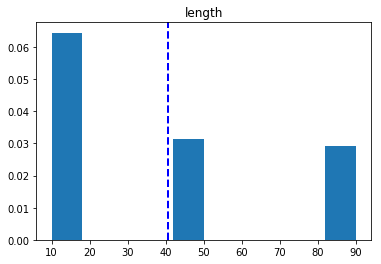

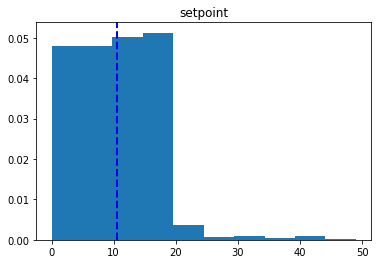

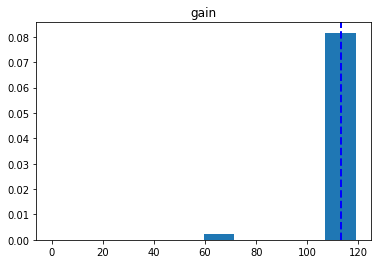

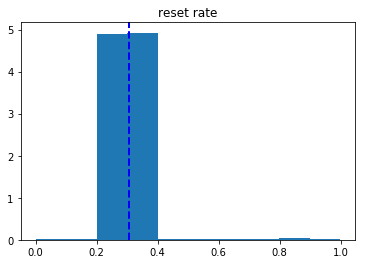

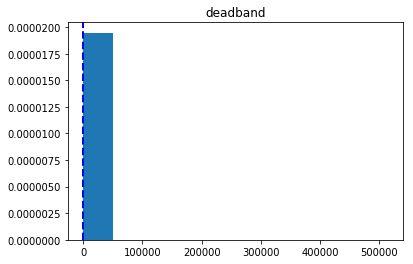

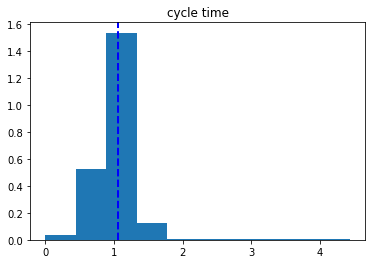

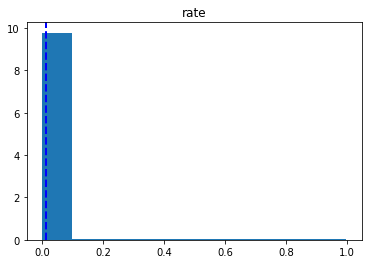

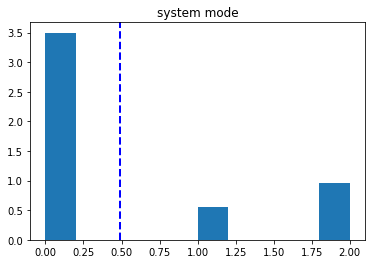

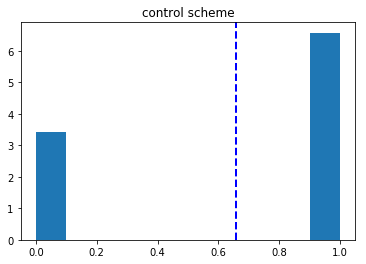

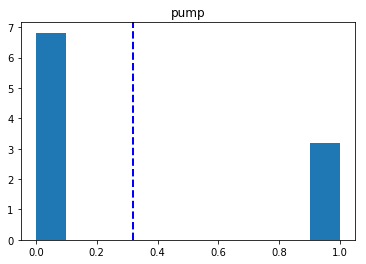

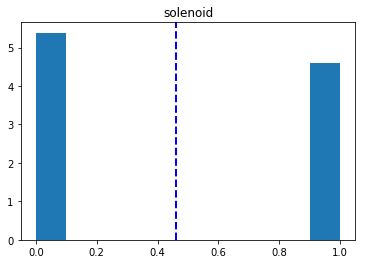

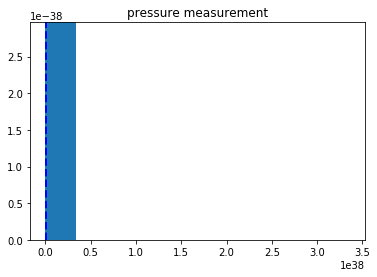

In [8]:
%matplotlib inline
def make_histograms(features, feature_names):
    n_bins = 10
    for n in range(features.shape[1]):
        xs = features[:, n]
        xs = xs[~np.isnan(xs)]
        plt.hist(xs, n_bins, normed=1, histtype='bar')
        plt.axvline(xs.mean(), color='b', linestyle='dashed', linewidth=2)
        plt.title(feature_names[n])
        plt.show()

make_histograms(remaining_features, remaining_feature_names)  

In [9]:
def split_dataset(data, labels, train_per_split, val_per_split, test_per_split):
    train_percentage_split      = train_per_split
    validation_percentage_split = val_per_split
    test_percentage_split       = test_per_split
    assert (train_percentage_split + validation_percentage_split + test_percentage_split) == 1.0
    
    train_end_index = int(data.shape[0] * train_percentage_split)
    valid_end_index = int(data.shape[0] * validation_percentage_split) + train_end_index

    X_train, Y_train = data[:train_end_index], labels[:train_end_index]
    X_valid, Y_valid = data[train_end_index:valid_end_index], labels[train_end_index:valid_end_index]
    X_test,  Y_test  = data[valid_end_index:], labels[valid_end_index:]
    assert X_train.shape[0] + X_valid.shape[0] + X_test.shape[0] == data.shape[0]
    
    return (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test)

In [37]:
(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = split_dataset(new_features, labels, .1 , .05, .85)

In [38]:
def merge_two_dicts(x, y):
    """Given two dicts, merge them into a new dict as a shallow copy."""
    z = x.copy()
    z.update(y)
    return z

def impute_simple(Xs, strategy = 'mean', stats = None):
    if not stats:
        Xs_imputer = preprocessing.Imputer(missing_values='NaN', strategy=strategy, axis=0)
        Xs  = Xs_imputer.fit_transform(Xs)
        Xs_stats = {}
        Xs_stats['impute'] = Xs_imputer.statistics_
        return Xs, Xs_stats
    else:
        for f_index in range(Xs.shape[1]):
            feature = Xs[:, f_index]
            feature[np.isnan(feature)] = stats['impute'][f_index]
            Xs[:, f_index] = feature
        return Xs, None

def normalize(Xs, stats = None):
    if not stats:
        Xs_scaler = preprocessing.StandardScaler()
        Xs = Xs_scaler.fit_transform(Xs)
        Xs_stats = {
            'mean'  : Xs_scaler.mean_,
            'scale' : Xs_scaler.scale_
        }
        return Xs, Xs_stats
    else:
        for f_index in range(Xs.shape[1]):
            feature = Xs[:, f_index]
            feature -= stats['mean'][f_index]
            feature /= stats['scale'][f_index]
            Xs[:, f_index] = feature
        return Xs, None

def preprocess_data(Xs, train_data_stats = None):
    #split again to pre-process each column adequately
    #no need to further pre-process these features
    addresses = Xs[:, 0]
    functions = Xs[:, 1:29]
    responses = Xs[:, 29]
    
    # features to be further pre-processed
    time_diffs   = Xs[:, 30].reshape((-1, 1))
    payload_feas = Xs[:, 31:-1]
    pressures    = Xs[:, -1].reshape((-1, 1))

    stats = None
    if not train_data_stats:
        stats = {}
        time_diffs, stats['time_diffs'] = normalize(time_diffs)
        
        payload_feas, payload_feas_impute_stats = impute_simple(payload_feas)
        payload_feas, payload_feas_norm_stats   = normalize(payload_feas)
        stats['payload'] = merge_two_dicts(payload_feas_impute_stats, payload_feas_norm_stats)
        
        pressures, pressures_impute_stats = impute_simple(pressures)
        pressures, pressures_norm_stats   = normalize(pressures)
        stats['pressures'] = merge_two_dicts(pressures_impute_stats, pressures_norm_stats)
        
    else:
        time_diffs, _ = normalize(time_diffs, train_data_stats['time_diffs'])

        payload_feas, _ = impute_simple(payload_feas, stats = train_data_stats['payload'])
        payload_feas, _ = normalize(payload_feas, train_data_stats['payload'])

        pressures, _ = impute_simple(pressures, strategy = 'median', stats = train_data_stats['pressures'])
        pressures, _ = normalize(pressures, train_data_stats['pressures'])


    Xs_preprocessed = np.column_stack((
        addresses,
        functions,
        responses,
        time_diffs,
        payload_feas,
        pressures
    ))
        
    return Xs_preprocessed, stats
    
X_train_preprocessed, X_train_stats = preprocess_data(X_train)
X_val_preprocessed,  _ = preprocess_data(X_valid, X_train_stats)
X_test_preprocessed, _ = preprocess_data(X_test, X_train_stats)
X_train_preprocessed.shape

(27462, 43)

In [45]:
def make_sequences(Xs, Ys, maxlen):
    X_seq, Y_seq = [], []
    for i in range(0, Xs.shape[0] - maxlen):
        X_seq.append(Xs[i: i+maxlen])
        Y_seq.append(Ys[i: i+maxlen])
    return np.array(X_seq), np.array(Y_seq)

maxlen = 7
X_train_seq, Y_train_seq = make_sequences(X_train_preprocessed, Y_train, maxlen)
X_val_seq, Y_val_seq     = make_sequences(X_val_preprocessed,   Y_valid, maxlen)
X_test_seq, Y_test_seq   = make_sequences(X_test_preprocessed,  Y_test, maxlen)
X_train_seq.shape, Y_train_seq.shape

((27455, 7, 43), (27455, 7, 1))

In [46]:
import importlib, Algorithm
Algorithm = importlib.reload(Algorithm)

model = Algorithm.one_layer_lstm(maxlen)

iters = 1

for iteration in range(60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X_train_seq, Y_train_seq, batch_size=128, epochs=1)
    score = model.evaluate(X_val_seq, Y_val_seq, batch_size=128, verbose=1)
    print(score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 7, 128)            88064     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 7, 1)              129       
_________________________________________________________________
activation_19 (Activation)   (None, 7, 1)              0         
Total params: 88,193
Trainable params: 88,193
Non-trainable params: 0
_________________________________________________________________

--------------------------------------------------
Iteration 0
Epoch 1/1
13724/13724 [==============================] - 2s     
12.6200879516

--------------------------------------------------
Iteration 1
Epoch 1/1
13696/13724 [============================>.] - ETA: 0s12.6200880138

--------------------------------------------------
Iteration 2
Epoch 1/1
13056/27455 [=============>................

KeyboardInterrupt: 

In [51]:
score = model.evaluate(X_test_batched, Y_test_batched, batch_size=100, verbose=1)


20500/54827 [==========>...................] - ETA: 12s

KeyboardInterrupt: 

In [27]:
predicted = model.predict(X_test_batched, batch_size=100, verbose=1)



54827/54827 [==============================] - 18s    


In [40]:
predicted == Y_test_batched.astype(np.float).reshape((-1, 1))

array([[False],
       [ True],
       [False],
       ..., 
       [ True],
       [False],
       [False]], dtype=bool)

In [41]:
labels

array([b'0', b'0', b'0', ..., b'1', b'0', b'0'], 
      dtype='|S1')

In [53]:
Y_train_batched

array([[ 0.],
       [ 0.],
       [ 1.],
       ..., 
       [ 0.],
       [ 1.],
       [ 1.]])